In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

sales = pd.read_csv('../data/processed/US_EV_SalesData.csv')

socioeconomic = pd.read_csv('../data/processed/state_year.csv')
socioeconomic['Stations Opened'] = socioeconomic['Stations Opened'].fillna(value=0)

data = pd.merge(sales, socioeconomic)
data = data[data['Year'] < 2020]

li_price = pd.read_csv('../data/processed/li_price.csv')
li_price.index = li_price['Year']
li_price = li_price.drop(columns=['Year'])
li_price = li_price.to_dict()['Price']

data['Li Battery Price'] = data['Year'].map(li_price)

PREDICTORS = ['Gasoline Price', 'Median Income', 'Population', 'Renewable Energy Use', 'Transportation Energy Use', 'Stations Opened']#, 'Li Battery Price']
RESPONSES = ['BEV sales', 'PHEV sales', 'Total']

lndata = pd.DataFrame()
for c in data.columns:
    if c in PREDICTORS or c in RESPONSES: lndata[c] = np.log(data[c] + 1)
    else: lndata[c] = data[c]

datasets = [data, data]
models = [LinearRegression(), RandomForestRegressor()]
names = ['OLS', 'Random forest']

fresh_data = pd.read_csv('../data/interim/socioeconomic_min_aicc_results.csv')
fresh_data = fresh_data.set_index(['Year', 'State', 'Prediction Years Out', 'Attribute'])
fresh_data = fresh_data[['Prediction']]
fresh_data = fresh_data.to_dict()['Prediction']

def gen_data(base_year, state, lookahead):
    d = {factor: [fresh_data[(base_year + i, state, i, factor)]
                  for i in range(1, lookahead + 1)]
         for factor in PREDICTORS}
    d['Year'] = [base_year + i for i in range(1, lookahead + 1)]
    df = pd.DataFrame(d)
    df['State'] = state
    return df
#
# MODELS = ['OLS', 'Log-log', 'Random forest']
#
# all_scores = {'State': data['State'].unique(),
#               **{model: [] for model in MODELS}}
# predictions = {model: {year: 0 for year in data['Year'].unique()}\
#                for model in MODELS}

In [2]:
for dataset, model, name in zip(datasets, models, names):
    train, validation = train_test_split(dataset, test_size=4/9, shuffle=False)
    # print(len(train))
    mod = model.fit(train[PREDICTORS], train['Total'])
    new = pd.DataFrame()
    new = pd.concat(gen_data(2015, state, 4) for state in dataset['State'].unique())
    error = np.sqrt(mean_squared_error(validation['Total'], mod.predict(new[PREDICTORS])))
    print(f'{name} error: {error}')

OLS error: 2566.384893031809
Random forest error: 2610.4528534971987


In [3]:
rf = RandomForestRegressor()
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, n_jobs = -1)
rf_random.fit(train[PREDICTORS], train['Total'])

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   verbose=2)

In [4]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': False}

In [5]:
predict = rf_random.predict(new[PREDICTORS])
np.sqrt(mean_squared_error(validation['Total'], predict))

2615.2291909581068

<BarContainer object of 6 artists>

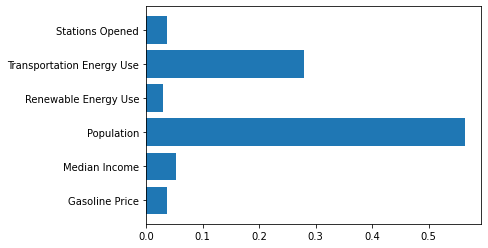

In [6]:
import matplotlib.pyplot as plt

plt.barh(PREDICTORS, mod.feature_importances_)

In [7]:
mod.feature_importances_

array([0.03649515, 0.05254781, 0.56436981, 0.0292036 , 0.27987355,
       0.03751009])

<AxesSubplot:xlabel='Year'>

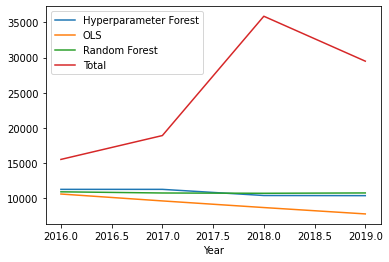

In [15]:
prediction_data = new
prediction_data['Hyperparameter Forest'] = rf_random.predict(new[PREDICTORS])
prediction_data['Random Forest'] = models[1].predict(new[PREDICTORS])
prediction_data['OLS'] = models[0].predict(new[PREDICTORS])
prediction_data = pd.merge(prediction_data, data, on=['State', 'Year'])
prediction_data = pd.pivot_table(prediction_data, index='Year', values=['Total', 'Hyperparameter Forest', 'Random Forest', 'OLS'], aggfunc=np.sum)
prediction_data.plot.line()

In [16]:
prediction_data

,Hyperparameter Forest,OLS,Random Forest,Total
Year,,,,
2016,11269.997857,10607.033301,10919.69,15527
2017,11269.997857,9625.486960,10752.73,18920
2018,10395.122857,8682.499294,10711.98,35884
2019,10374.372857,7777.778668,10759.77,29497


In [17]:
new

,Gasoline Price,Median Income,Population,Renewable Energy Use,Transportation Energy Use,Stations Opened,Year,State,Hyperparameter Forest,Random Forest,OLS
0,18.7608,20975.348461,2.990056e+06,118342.019641,2.724695e+05,4.073781,2016,AR,70.222222,76.79,258.340403
1,19.1416,20086.643100,2.999730e+06,113755.388532,2.696496e+05,4.284374,2017,AR,70.222222,75.52,227.873755
2,19.5224,19441.110646,3.008755e+06,111312.983328,2.666702e+05,4.494967,2018,AR,70.222222,74.88,204.874867
3,19.9032,18981.289079,3.017130e+06,106069.017493,2.635314e+05,4.705561,2019,AR,70.222222,74.84,187.042630
0,20.0308,29794.779742,1.282820e+07,338946.291667,1.075016e+06,64.227713,2016,IL,2179.625000,2156.42,1677.324566
1,20.4416,28557.441678,1.279093e+07,323098.875000,1.116667e+06,72.243141,2017,IL,2179.625000,2086.85,1527.912054
2,20.8524,27088.199836,1.274778e+07,306289.750000,1.161029e+06,80.683935,2018,IL,1284.000000,1969.01,1364.488505
3,21.2632,25857.370285,1.269874e+07,288518.916667,1.208102e+06,89.550094,2019,IL,1284.000000,1990.95,1200.865756
0,19.3688,25011.520000,6.625066e+06,257026.766161,6.147512e+05,20.500862,2016,IN,736.375000,673.72,766.111406
1,19.7776,24125.040000,6.636892e+06,273741.878406,6.183695e+05,23.119669,2017,IN,736.375000,645.27,719.541887
